In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist['data'] ,mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
first_digit = X[0]
first_digit_reshape = first_digit.reshape(28,28)


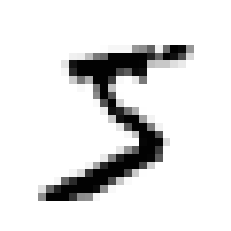

In [7]:
plt.imshow(first_digit_reshape,cmap='Greys',vmin=0,vmax=255)
plt.axis('off')
plt.show()

In [8]:
y[0]

'5'

In [9]:
import numpy as np
y = y.astype(np.uint8)

In [10]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Let start with classifying one digit at a time

In [11]:
y_train_5 = (y_train ==5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([first_digit])

array([ True])

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Being a skwed dataset, wherein the distribution is uneven considering there are about 95% images which are not 5 and can randomly set majority to false. Thus for these kind of dataset accuracy cannot be a good major

Consider a custom estimator

In [14]:
from sklearn.base import BaseEstimator
class Not5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [15]:
not_5_clf = Not5Classifier()
cross_val_score(not_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This random custom estimator also gives about 90% accuracy which cannot be consider good major for the same reason

considering Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

here each row defines actual value and the column the predicted value, 1st row is negative value(not 5) and the 2nd represents positive values(images which are 5). Ideally confusion matrix should only have non zeros diagonal elements (top left and bottom right)

More precise measure is accuracy of positive prediction known are precision of classifier another metric is recall or the true positive rate

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

here classifier to detect 5 was 83% correct, it could detect only 65% of 5's out of total number of 5 present

convenient way is to combine precision and recall into f1 score, its the harmonic mean of the two and its higher only if both the values are higher

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

F1 score depends on both precision and recall, but in some cases higher precision is preferred while in others higher recall.
To define in general terms,
precision : is ratio number of instance correctly classified as true value to total number of instanses classified as true(this include true positive and false positive)
recall : is the ratio of number of instance correctly classified as true value to total number of true value instanse(true positive & false negative)

cannot set the threshold directly but can calculate desicion score for each instance

In [21]:
y_score_fd = sgd_clf.decision_function([first_digit])
y_score_fd 

array([2164.22030239])

In [22]:
threshold = 0
y_pred_first_digit = (y_score_fd>threshold)
y_pred_first_digit

array([ True])

In [23]:
y[0]

5

as seen considering the threshold as 0 and comparing with the instance score of the first value we could predict correctly the first instance to be 5
Lets try by increasing the threshold

In [24]:
threshold = 5000
y_pred_first_digit = (y_score_fd>threshold)
y_pred_first_digit

array([False])

now the value is wrongly interpreted as false, false negative case, indicating that raising threshold decreases recall

to decide upon the threshold value, calculate score for each instance

In [25]:
y_score = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method = 'decision_function')

precision_recall_curve() this function is used to calculate presicion, recall and threshold for each instance and only applicable on binary classifier
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

In [26]:
from sklearn.metrics import precision_recall_curve
precision , recall , threshold = precision_recall_curve(y_train_5,y_score)

In [27]:
def plot_pre_re_thre_curve(precision,recall,threshold):
    plt.plot(threshold,precision[:-1],"b--",label="precision")
    plt.plot(threshold,recall[:-1],"g-",label="recall")
    plt.legend()
    plt.xlabel('threshold')

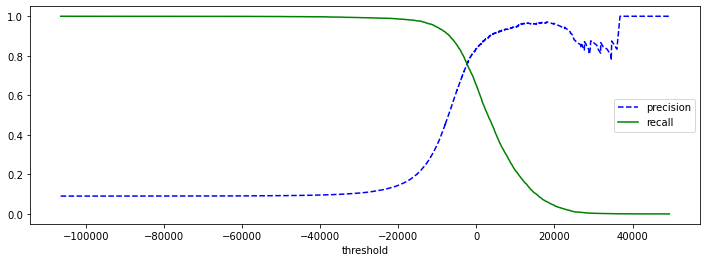

In [28]:
plt.figure(figsize=(12,4))
plot_pre_re_thre_curve(precision,recall,threshold)


Curve for precision vs recall

Text(0, 0.5, 'precision')

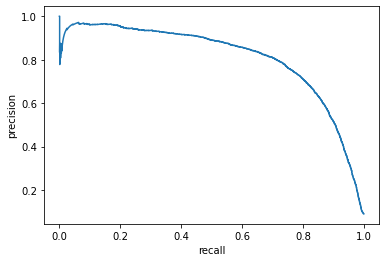

In [29]:
plt.plot(recall[:-1],precision[:-1])
plt.xlabel("recall")
plt.ylabel("precision")

there is shrap decrese in the precision value with the increase in the recall value around 80%

considering we need 90% precision, to calculate the min threshold which will correspond

In [30]:
th_90_precision = threshold[np.argmax(precision>=0.9)]

In [31]:
th_90_precision

3370.0194991439594

In [32]:
y_train_90_pre = (y_score>=th_90_precision)

In [33]:
precision_score(y_train_5,y_train_90_pre)

0.9000345901072293

In [34]:
recall_score(y_train_5,y_train_90_pre)

0.4799852425751706

The other common tool is ROC(Receiver operating characteristic) 
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [35]:
from sklearn.metrics import roc_curve
fpr,tpr,threshold = roc_curve(y_train_5,y_score)

In [36]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,label=label)
    plt.plot([0,1],[0,1],"k--")

Text(0, 0.5, 'True positive rate(Recall)')

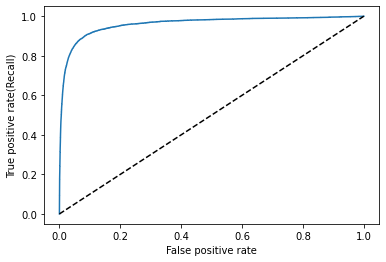

In [37]:
plot_roc_curve(fpr,tpr)
# plt.figure(figsize=(12,4))
plt.xlabel("False positive rate")
plt.ylabel('True positive rate(Recall)')

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_score)

0.9604938554008616

both the curve are similarle, the choice depends upon what are we looking, PR curve is prefer when the positive class is rare or when we care more about false positive then false negative.

comparing the ROC AUC for random forest classifier and SGDClassifier

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [40]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest , tpr_forest, threshold_forest = roc_curve(y_train_5,y_scores_forest)

Text(0, 0.5, 'true positive rate')

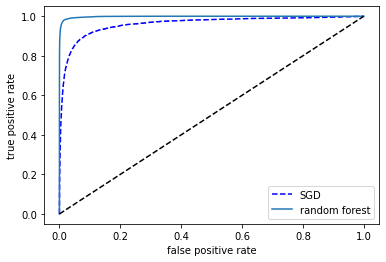

In [41]:
plt.plot(fpr,tpr,'b--',label ='SGD')
plot_roc_curve(fpr_forest,tpr_forest,"random forest")
plt.legend(loc="lower right")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [42]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

Now moving to multiclass classification, to classify amongst the 10 digits. The ways do it, first is to create individual classifier to detect one digit eg. 1-detector, 2-detector,etc. To classify an individual image pass that image into each classifier, taking the decidion score, one with highest score is the label of the image This method is called one-versus-the-rest(OvR)
Second method is to detect between the given to number between eg diff between 0 or 1, 1 or 2, likewise. This is called to be one-versus-one(OvO). Main advantage is the needs to be trained over the small training set over the images it need to distinguish. To classify amongst the 10 digits it need to run the about 45 classifier, get the score and decide based on the highest score.

SGD classifier, Random Forest classifier and naive Bayes classifier are capable to handle multiple classes, whereas Logistic Regression or Support Vector Machine classifier are for binary classification

In [43]:
from sklearn.svm import SVC
svm_clf =SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([first_digit])

array([5], dtype=uint8)

Scikit learn uses the OvO under the hood, uses the 45 classifier, get the score for the 10 digit which ever scored the highest is labeled as the output 

In [44]:
first_digit_score  = svm_clf.decision_function([first_digit])
first_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
np.argmax(first_digit_score)

5

In [46]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
svm_clf.classes_[5]

5

classes_ is an attribute of svm estimator and the '_' is used to determine its an attribute. It store the label of all the classes

We could explicitly use OvO or OvR

trying SGDclassifier, it wont be using OvO or OvR as it could classify multiple classes

In [48]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([first_digit])

array([3], dtype=uint8)

In [49]:
sgd_clf.decision_function([first_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
y_train[0]

5

The modeled got confused and predict 3 instead of actual 5

In [51]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

accuracy is around an average of 85%, but we could increase the prediction by scaling the input

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled =scaler.fit_transform(X_train.astype(np.float32))

In [53]:
sgd_clf.fit(X_train_scaled,y_train)
sgd_clf.predict([first_digit])

array([3], dtype=uint8)

still predicting 3 which is wrong lets analysis the error, for that we use confusion matix which in turn requires to use cross_val_predict

In [54]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5578,    0,   22,    5,    8,   43,   36,    6,  224,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5215,   92,   72,   27,   67,   37,  383,   11],
       [  23,   17,  117, 5224,    2,  202,   26,   40,  407,   73],
       [  12,   14,   41,    9, 5183,   12,   34,   27,  348,  162],
       [  26,   15,   29,  167,   53, 4442,   75,   14,  540,   60],
       [  30,   15,   42,    3,   43,   98, 5551,    3,  132,    1],
       [  21,   10,   51,   29,   49,   12,    3, 5682,  200,  208],
       [  17,   64,   48,   87,    3,  126,   25,   10, 5428,   43],
       [  25,   18,   30,   64,  118,   36,    1,  179,  382, 5096]],
      dtype=int64)

The matix value has higher value along the diagonal but for more clear understanding lets plot using matshow()

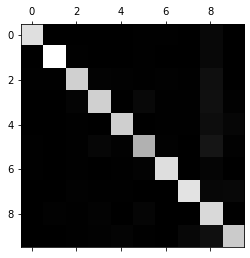

In [55]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

now quiet clear the values around the diagonal are the desirable but we need to find the reason behind why the system is confused between 3 and 5 or there are any other misinterpretation 

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

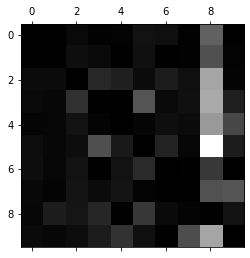

In [57]:
np.fill_diagonal(norm_conf_mx,0)   #to fill the diagonal values 0 to highlight the error rates
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

the row represents the actual value and the column the predicted values. Many numbers seems to be wrongly predicted as 8 but the actual 8 seems to be predicted well, to over come this issue the classifier needs to be trained with more digits written similar to 8 and decude some algo to identify it as in 8 has two loops, 6 has one and 5 or 1 has none.
Likewise our case the system is confused between 3 and 5 and its seen in the plot also there are errors to predict 5 and 3 

In [58]:
cl_a , cl_b = 3,5
x_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
x_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
x_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
x_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

Regarding subplot https://pythonprogramming.net/subplot2grid-add_subplot-matplotlib-tutorial/

In [59]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

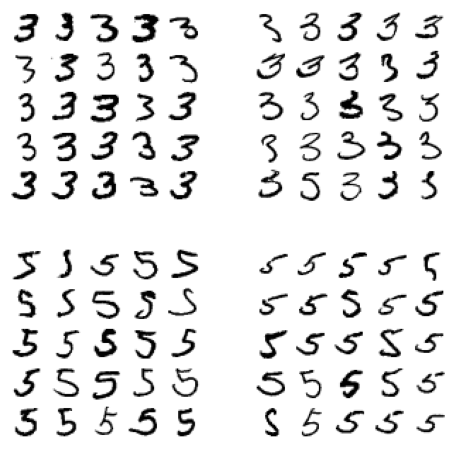

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(x_aa[:25],images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25],images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25],images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25],images_per_row=5)
plt.show()

The left column 2 blocks are for classifier identified as 3 and the right block is as 5. There are many wrong digits wrongly interpreted as we are using SGDclassifier it is sensitive to the orientation of the image, the basic idealogy is it assigns weight per class to each pixel, since 3 and 5 have similar pixel it get confused

Multilabel classifier:
until now we had one class per instance, there are scenarios where there can be more than label per instance. This is the case for Multilabel classifier.   

In [61]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([first_digit])

array([[False,  True]])

The output is correct the first digit is 5, which is less than 7 and odd

The other way to compute is by using f1 score, consider the even correunce of the images so accuracy = 'macro', if we had skwed dataset we could use 'weighted' depending on the number of classes present

In [64]:
# y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
# f1_score(y_multilabel,y_train_knn_pred,average='macro')

Multioutput Classification:
Each instance has multiple label and for each label classification can have multiple values.Like in an image data each pixel is an label and each label can have intensity from 0 to 255

In [66]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

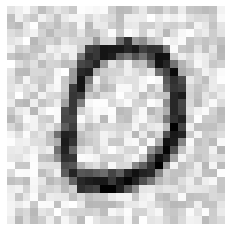

In [68]:
random_img = X_test_mod[10]
random_img_reshape = random_img.reshape(28,28)
plt.imshow(random_img_reshape,cmap='binary')
plt.axis('off')
plt.show()

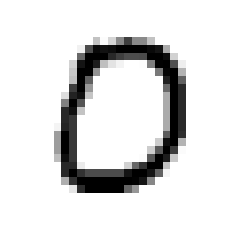

In [69]:
random_img = y_test_mod[10]
random_img_reshape = random_img.reshape(28,28)
plt.imshow(random_img_reshape,cmap='binary')
plt.axis('off')
plt.show()

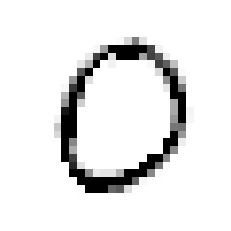

In [72]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[10]])
plot_digits(clean_digit)

Additional links:
Theory over the diff types of classifier:
https://machinelearningmastery.com/types-of-classification-in-machine-learning/